In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import datetime as dt
import plotly.express as px

In [14]:
name_DF = pd.read_csv(r"C:\Users\agori\Downloads\Projet 2\name_basics.tsv", sep = "\t", low_memory = False)

In [16]:
basics_DF = pd.read_csv(r"C:\Users\agori\Downloads\Projet 2\title_basics.tsv", sep = "\t", low_memory = False)

In [17]:
principals_DF = pd.read_csv(r"C:\Users\agori\Downloads\Projet 2\title_principals.tsv", sep = "\t", low_memory = False)

# SELECTIONS DES COLONNES UTILES

In [18]:
name_DF.drop('deathYear', axis = 1, inplace = True)
name_DF.drop('knownForTitles', axis = 1, inplace = True) 

In [19]:
basics_DF.drop('primaryTitle', axis = 1, inplace = True)
basics_DF.drop('isAdult', axis = 1, inplace = True)
basics_DF.drop('endYear', axis = 1, inplace = True)

In [20]:
principals_DF.drop('job', axis = 1, inplace = True)
principals_DF.drop('characters', axis = 1, inplace = True)

# NETTOYAGE ET FILTRES

In [21]:
# Nettoyage de la base relative aux acteurs
name_clean_nan = name_DF.dropna(subset = ['primaryProfession'])
name_clean_nan = name_clean_nan[name_clean_nan['primaryProfession'].str.contains('actor|actress')]
name_clean = name_clean_nan[name_clean_nan['birthYear'] != '\\N']

# --> nous avons maintenant un DF contenant uniquement des acteurs et actrices, et dont la colonne 'birthYear' est renseignée

In [22]:
# Nettoyage de la base relative aux films et films tv :
basics_DF = basics_DF[basics_DF['titleType'].str.contains('movie|tvMovie')]
basics_DF_clean1 = basics_DF[basics_DF['runtimeMinutes'] != '\\N']
basics_DF_clean2 = basics_DF_clean1.astype({"runtimeMinutes": int})
basics_DF_clean = basics_DF_clean2[basics_DF_clean2['runtimeMinutes'] >= 60]
basics_DF_clean = basics_DF_clean.dropna(subset = ['startYear'])
basics_DF_clean = basics_DF_clean[basics_DF_clean['startYear'] != '\\N']
basics_DF_clean = basics_DF_clean.astype({"startYear": int})
basics_DF_clean = basics_DF_clean[basics_DF_clean['startYear'] >= 1894 ]

# --> nous avons maintenant un DF contenant uniquement des films et des films tv dont la durée est supérieure à 60 minutes et dont nous avons des 'startYear' renseignés

In [23]:
# Nettoyage de la base relative category, contenant les clés des 2 tables précédentes :
principals_DF = principals_DF[principals_DF['category'].str.contains('actor|actress')]

# --> nous pouvons maintenant joindre les 2 bases de données grâce à cette table commune

# MERGE DES DF

In [24]:
# Merge principals_DF avec name_clean :

Act_DF = pd.merge(name_clean,principals_DF, how = 'left', left_on=['nconst'], right_on=['nconst'])

In [25]:
# Merge Act_DF avec basics_DF_clean :

Age_DF = pd.merge(Act_DF,basics_DF_clean, how = 'right', left_on=['tconst'], right_on=['tconst'])
Age_DF.reset_index(inplace = True)

In [26]:
Age_DF.isna().sum()

index                     0
nconst               122329
primaryName          122329
birthYear            122329
primaryProfession    122329
tconst                    0
ordering             122329
category             122329
titleType                 0
originalTitle             0
startYear                 0
runtimeMinutes            0
genres                    0
dtype: int64

In [27]:
# On remarque que des films n'ont pas d'acteurs à mettre en face. 
# Nous allons donc supprimer ces lignes qui n'ont pas lieu d'être :
Age_DF = Age_DF.dropna(subset = ['nconst'])

In [28]:
Age_DF.isna().sum()

index                0
nconst               0
primaryName          0
birthYear            0
primaryProfession    0
tconst               0
ordering             0
category             0
titleType            0
originalTitle        0
startYear            0
runtimeMinutes       0
genres               0
dtype: int64

In [29]:
Age_DF.isin(['\\N']).sum(axis = 0)

index                    0
nconst                   0
primaryName              0
birthYear                0
primaryProfession        0
tconst                   0
ordering                 0
category                 0
titleType                0
originalTitle            0
startYear                0
runtimeMinutes           0
genres               46691
dtype: int64

In [30]:
# Notre base est dorénavant propre.
# Nous allons donc ajouter 1 colonne : celle de l'âge de l'acteur au moment de la 'startYear' :
# Mais avant nous devons transformer les 2 colonnes souhaitées en int :
Age_DF = Age_DF.astype({"startYear": int,"birthYear": int })
Age_DF['Age'] = Age_DF['startYear'] - Age_DF['birthYear']

In [31]:
Age_DF['Age'].unique()

array([  27,   35,   33,   34,   47,   38,   23,   43,    6,   28,   25,
         67,   36,   42,   26,   30,   37,   22,   48,   32,   40,   31,
         24,   49,   39,   66,   59,   41,   56,   45,   62,   54,   63,
         60,   46,   61,   11,   21,   15,   19,   51,    8,   52,   18,
         58,   20,   64,   50,   14,   69,   16,   29,   44,   73,   70,
          9,   12,   53,   68,   55,   17,   84,   72,   65,   71,   57,
          5,   80,   81,    7,    4,   75,   10,   13,   -1,    3,   79,
         76,   74,   77,  133,  132,   78,   82,  124,  122,    2,   -3,
         83,    1,  -15,   85,  107,  101,   95,   90,   87,   88,   -2,
         91,   92,  100,  106,   86,   -5,   89,  112,   -6,   93,   -7,
         97,   94,   98,    0,  -30,   99,  102,  -32, 1955,   -4,  131,
        105,   96,  113,  110,  111,  129,  104,  116,  -18,  103,  121,
        108,  148])

In [32]:
# Malgré notre nettoyage des bases de données, nous rencontrons des outliers liés à des fautes de frappe ou autre
# Nous allons donc nettoyer la base pour enlever les outliers (la valeur la + haute sera 110 car à notre connaissance, l'actrice la plus âgée ayant tourné avait 104 ans)

Age_DF_clean_out = Age_DF[Age_DF['Age'] <= 110]
Age_DF_clean = Age_DF_clean_out[Age_DF_clean_out['Age'] >= 0]


In [33]:
Age_DF_clean.reset_index(inplace = True)

In [22]:
# Notre DF est prêt mais nous allons ajouter une colonne période pour présenter nos données :
#Age_DF_clean['periode'] = (Age_DF_clean['startYear'] //10) *10

C:\Users\agori\AppData\Local\Temp/ipykernel_7492/3906605017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Age_DF_clean['periode'] = (Age_DF_clean['startYear'] //10) *10


In [34]:
Age_DF_clean

,level_0,index,nconst,primaryName,birthYear,primaryProfession,tconst,ordering,category,titleType,originalTitle,startYear,runtimeMinutes,genres,Age
0,1,1,nm0846887,Elizabeth Tait,1879,actress,tt0000574,1.0,actress,movie,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",27
1,2,2,nm0846894,John Tait,1871,"actor,producer",tt0000574,2.0,actor,movie,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",35
2,3,3,nm0906197,Georges Wague,1874,actor,tt0000591,1.0,actor,movie,L'enfant prodigue,1907,90,Drama,33
3,4,4,nm1323543,Christiane Mandelys,1873,actress,tt0000591,3.0,actress,movie,L'enfant prodigue,1907,90,Drama,34
4,7,7,nm0470307,Henry Krauss,1866,"actor,director,writer",tt0001790,1.0,actor,movie,Les misérables - Époque 1: Jean Valjean,1913,60,Drama,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818002,940382,940382,nm8678236,Lala Karmela,1985,actress,tt9916538,1.0,actress,movie,Kuambil Lagi Hatiku,2019,123,Drama,34
818003,940384,940384,nm0952498,Zbigniew Zamachowski,1961,"actor,soundtrack,composer",tt9916692,4.0,actor,tvMovie,Teatroteka: Czlowiek bez twarzy,2015,66,Drama,54
818004,940385,940385,nm1410499,Sambor Czarnota,1977,actor,tt9916692,1.0,actor,tvMovie,Teatroteka: Czlowiek bez twarzy,2015,66,Drama,38
818005,940386,940386,nm1697691,Marzena Bergmann,1975,actress,tt9916692,2.0,actress,tvMovie,Teatroteka: Czlowiek bez twarzy,2015,66,Drama,40


In [35]:
Age_DF_clean.drop('level_0', axis = 1, inplace = True)
Age_DF_clean.drop('index', axis = 1, inplace = True)
Age_DF_clean.drop('nconst', axis = 1, inplace = True)
Age_DF_clean.drop('primaryProfession', axis = 1, inplace = True)
Age_DF_clean.drop('ordering', axis = 1, inplace = True)
Age_DF_clean.drop('runtimeMinutes', axis = 1, inplace = True)
Age_DF_clean.drop('tconst', axis = 1, inplace = True)
Age_DF_clean.drop('originalTitle', axis = 1, inplace = True)
Age_DF_clean.drop('primaryName', axis = 1, inplace = True)
Age_DF_clean.drop('birthYear', axis = 1, inplace = True)
Age_DF_clean = Age_DF_clean[Age_DF_clean['startYear'] >= 1960 ]
Age_DF_clean.reset_index(inplace = True)


C:\Users\agori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,primaryName,birthYear,tconst,category,titleType,originalTitle,startYear,genres,Age
0,Elizabeth Tait,1879,tt0000574,actress,movie,The Story of the Kelly Gang,1906,"Action,Adventure,Biography",27
1,John Tait,1871,tt0000574,actor,movie,The Story of the Kelly Gang,1906,"Action,Adventure,Biography",35
2,Georges Wague,1874,tt0000591,actor,movie,L'enfant prodigue,1907,Drama,33
3,Christiane Mandelys,1873,tt0000591,actress,movie,L'enfant prodigue,1907,Drama,34
4,Henry Krauss,1866,tt0001790,actor,movie,Les misérables - Époque 1: Jean Valjean,1913,Drama,47
...,...,...,...,...,...,...,...,...,...
818002,Lala Karmela,1985,tt9916538,actress,movie,Kuambil Lagi Hatiku,2019,Drama,34
818003,Zbigniew Zamachowski,1961,tt9916692,actor,tvMovie,Teatroteka: Czlowiek bez twarzy,2015,Drama,54
818004,Sambor Czarnota,1977,tt9916692,actor,tvMovie,Teatroteka: Czlowiek bez twarzy,2015,Drama,38
818005,Marzena Bergmann,1975,tt9916692,actress,tvMovie,Teatroteka: Czlowiek bez twarzy,2015,Drama,40


In [55]:
Age_DF_clean

,index,category,titleType,startYear,genres,Age
0,10666,actor,movie,1993,"Drama,Mystery,Romance",64
1,10667,actress,movie,1993,"Drama,Mystery,Romance",29
2,10668,actress,movie,1993,"Drama,Mystery,Romance",35
3,49100,actor,movie,1970,Comedy,37
4,49101,actor,movie,1970,Comedy,64
...,...,...,...,...,...,...
653325,818002,actress,movie,2019,Drama,34
653326,818003,actor,tvMovie,2015,Drama,54
653327,818004,actor,tvMovie,2015,Drama,38
653328,818005,actress,tvMovie,2015,Drama,40


In [56]:
#compression_opts = dict(method='zip',archive_name='Age_acteurs20211118.csv') 
#Age_DF_clean.to_csv('Age_acteurs20211118.zip', index=False,compression=compression_opts) 

# STATS

In [57]:
Age_Moyen = pd.read_csv(r"C:\Users\agori\OneDrive\Documents\GitHub\Movie_Recommandation\Streamlit\Age_acteurs20211118.csv", sep = "\t", low_memory = False)

In [60]:
# Moyenne âge acteurs de films :
# Calcul de la moyenne d'âge avec .mean() + utilisation de round() pour arrondir le résultat : 

Age_Moyen = round(Age_DF_clean['Age'].mean())
print("La moyenne d'âge des acteurs de films est de", Age_Moyen, "ans au moment des tournages.")

La moyenne d'âge des acteurs de films est de 40 ans au moment des tournages.


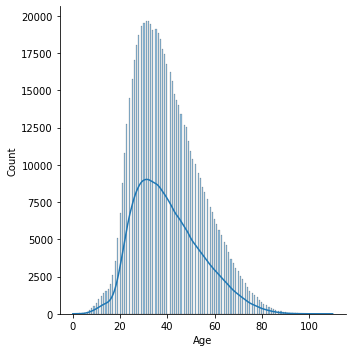

In [61]:
sns.displot(Age_DF_clean['Age'], kde=True)

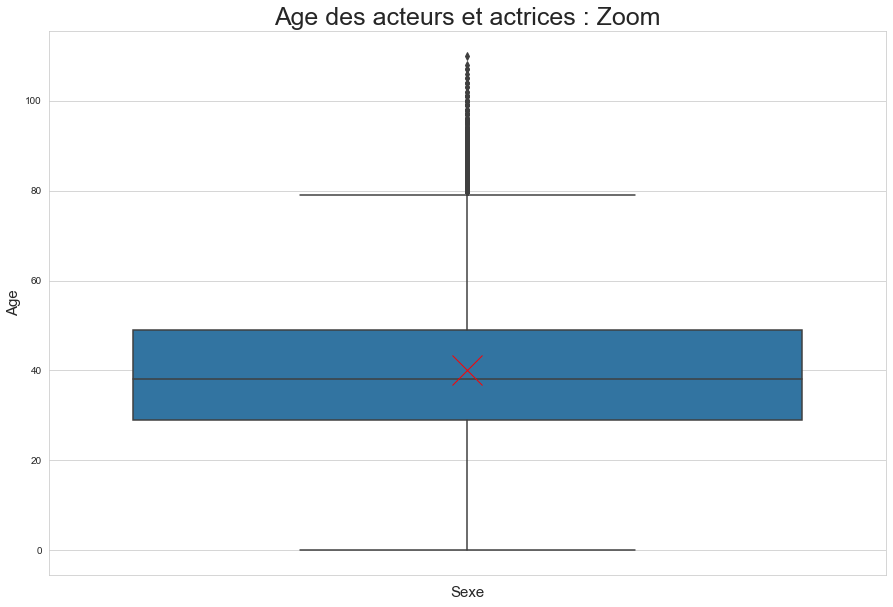

In [76]:
fig, axes = plt.subplots(figsize=(15, 10))

sns.set_style("whitegrid")
boxplot = sns.boxplot(data=Age_DF_clean,  y="Age",
                        showmeans=True, meanprops={"marker": "x", "markeredgecolor": "red", "markersize": "30"})


boxplot.axes.set_title('Age des acteurs et actrices : Zoom',fontsize=25)
boxplot.set_xlabel("Sexe", size = 15)
boxplot.set_ylabel('Age', size = 15)
boxplot.tick_params(labelsize = 10)

moyenne = round(Age_DF_clean['Age'].mean())

plt.show()

In [63]:
print(" Age des acteurs et actrices : Statistiques :")
print(' ')
print("L'âge moyen des acteurs, tout sexe confondu, est de", moyenne, "ans.")

 Age des acteurs et actrices : Statistiques :
 
L'âge moyen des acteurs, tout sexe confondu, est de 40 ans.


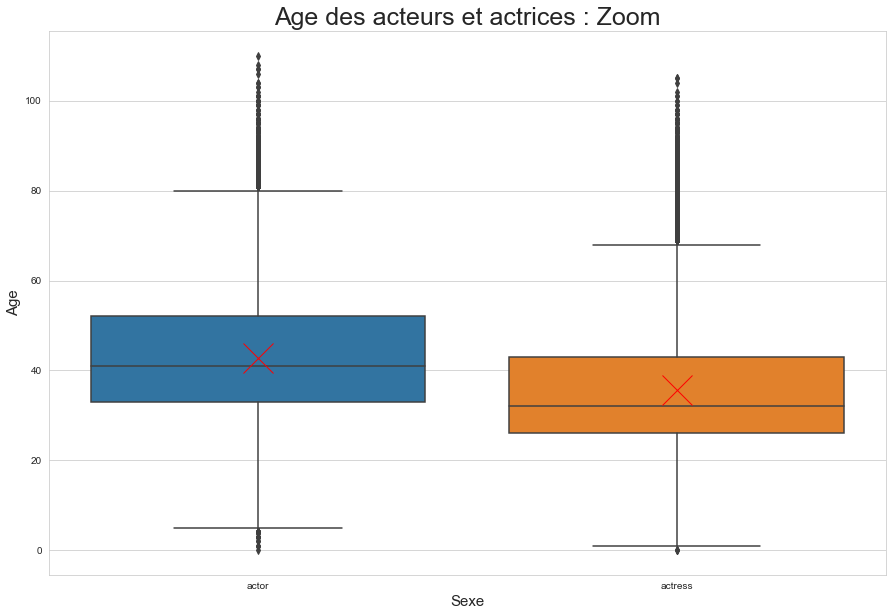

In [74]:
fig, axes = plt.subplots(figsize=(15, 10))

sns.set_style("whitegrid")
boxplot = sns.boxplot(data=Age_DF_clean,  x="category", y="Age",
                        showmeans=True, meanprops={"marker": "x", "markeredgecolor": "red", "markersize": "30"})


boxplot.axes.set_title('Age des acteurs et actrices : Zoom',fontsize=25)
boxplot.set_xlabel("Sexe", size = 15)
boxplot.set_ylabel('Age', size = 15)
boxplot.tick_params(labelsize = 10)

plt.show()

In [65]:
stats_Mean_ages_pivot = ((Age_DF_clean.pivot_table(values='Age', index='category', aggfunc='mean')).round()).astype(int)
stats_Median_ages_pivot = Age_DF_clean.pivot_table(values='Age', index='category', aggfunc='median')
print(" Age des acteurs et actrices : Statistiques :")
print(' ')
print("Voici les moyennes d'âge par sexe : \n", stats_Mean_ages_pivot)
print(' ')
print("Voici l'âge central des populations sexe :\n", stats_Median_ages_pivot)

 Age des acteurs et actrices : Statistiques :
 
Voici les moyennes d'âge par sexe : 
           Age
category     
actor      43
actress    36
 
Voici l'âge central des populations sexe :
           Age
category     
actor      41
actress    32


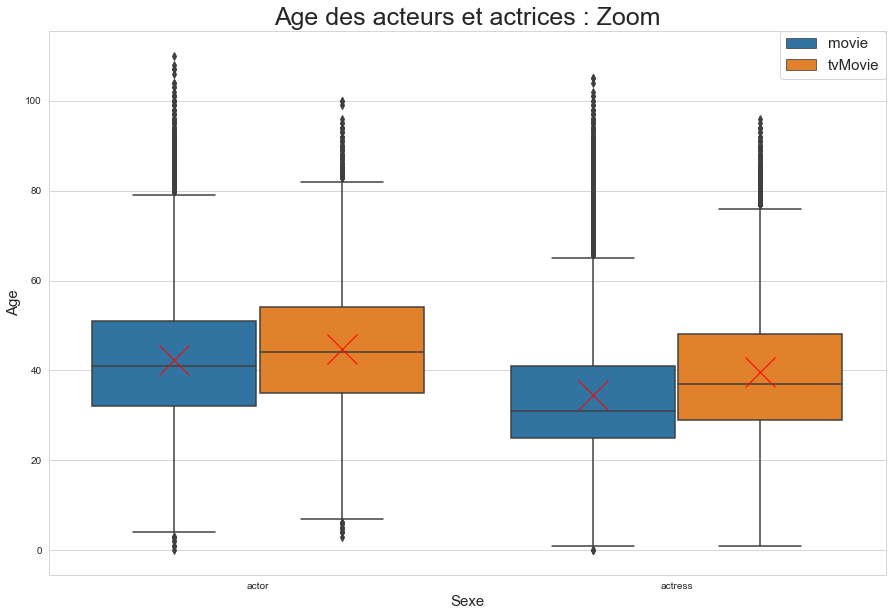

In [73]:
fig, axes = plt.subplots(figsize=(15, 10))

sns.set_style("whitegrid")
boxplot = sns.boxplot(data=Age_DF_clean,  x="category", y="Age", hue = 'titleType',
                        showmeans=True, meanprops={"marker": "x", "markeredgecolor": "red", "markersize": "30"})


boxplot.axes.set_title('Age des acteurs et actrices : Zoom',fontsize=25)
boxplot.set_xlabel("Sexe", size = 15)
boxplot.set_ylabel('Age', size = 15)
boxplot.tick_params(labelsize = 10)
boxplot.legend(loc = 'upper right', prop={'size': 15}, borderaxespad=0.)

plt.show()

In [67]:
stats_Mean_ages_pivot = ((Age_DF_clean.pivot_table(values='Age', index='category', columns='titleType', aggfunc='mean')).round()).astype(int)
stats_Median_ages_pivot = Age_DF_clean.pivot_table(values='Age', index='category', columns='titleType', aggfunc='median')
print(" Age des acteurs et actrices : Statistiques :")
print(' ')
print("Voici les moyennes d'âge par sexe et par catégorie de film: \n", stats_Mean_ages_pivot)
print(' ')
print("Voici l'âge central des populations sexe et par catégorie de film:\n", stats_Median_ages_pivot)

 Age des acteurs et actrices : Statistiques :
 
Voici les moyennes d'âge par sexe et par catégorie de film: 
 titleType  movie  tvMovie
category                 
actor         42       45
actress       35       40
 
Voici l'âge central des populations sexe et par catégorie de film:
 titleType  movie  tvMovie
category                 
actor         41       44
actress       31       37
